### Plan:
- dla każdego modelu OSOBNO poprzez crosswalidację sprawdzamy najlepsze rozkłady parametrów (SearchGrid lub bayesowsko)
- dla najlepszych parametrów (dla modelu) rysujemy auc curve i wypisujemy statystyki (sprawdzenie na zbiorze testowym) oraz wyniki z crosswalidacji na całym zbiorze danych
- następnie próbujemy stackingu, votingu itp
- znowu sprawdzamy boxploty
### Co przyjąłem
- do każdego modelu bierzemy pipeline z jednakowo preproccesingowanymi danymi: bez oczywistych kolumn (ale days zostawiam jednak przetransformowane kołowo), ponadto minmaxy i te binnery co były w poprzedniej części

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# Ramka danych i preproccesing wstępny
from sklearn.model_selection import train_test_split

seed = 17
bank_data = pd.read_csv("./Data/bank_train_data.csv", index_col=0)

## Kategoryczne niebinarne
# Oridinal education
bank_data['education'] = bank_data['education'].map({'unknown': 0, 'primary': 1, 'secondary': 2, 'tertiary': 3})

# OneHot reszty
bank_data = pd.get_dummies(bank_data, columns=['job','contact','marital','poutcome'])

## Kategoryczne binarne
binary = ["default", "housing", "loan", "y"]
for col in binary:
    bank_data[col] = bank_data[col].map({"yes": 1, "no": 0})

# Month (tranfosrmacja na okrąg)
bank_data['month'] = bank_data["month"].map({"jan": 0, "feb": 1, "mar": 2, "apr": 3, "may": 4, "jun": 5, "jul": 6, "aug": 7, "sep": 8, "oct": 9, "nov": 10, "dec": 11})
bank_data['month'] = bank_data["month"].apply(lambda x: np.sin(x * (2 * np.pi / 12)))

# Day (transformacja na okrąg)
bank_data['day'] = bank_data["day"].apply(lambda x: np.sin(x * (2 * np.pi / 31)))
X = bank_data.drop("y", axis=1)
y = bank_data["y"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, stratify=y, test_size=0.2)

# 0. Pomocnicze

## 0.1 Klasy do pipeline

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin

# Klasa do wyrzucania kolumn w pipelinie
class ColumnDropper(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.drop(self.columns, axis = 1)
    
# Klasa do logarytmowania i następnie standaryzowania kolumn
class LogStdTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.std_scalers = [StandardScaler() for _ in range(len(columns))]
    
    def fit(self, X, y=None):
        
        for i, col in enumerate(self.columns):
            self.std_scalers[i].fit(np.log1p(X[[col]]))
            
        return self
    
    def transform(self, X, y=None):
        
        df = X.copy()
        
        for i, col in enumerate(self.columns):
            df[col] = self.std_scalers[i].transform(np.log1p(X[[col]]))
        
        return df

# Klasa do binnowania cechy balance
class BalanceBinner(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        curr_balance = X["balance"]
        new_balance = balance = pd.cut(curr_balance, bins = [-np.inf, 0, 1500, np.inf], labels=[0, 1, 2]).cat.codes
        return X.drop("balance", axis=1).assign(balance = new_balance)
    
# Klasa do transoformowania cech na przedział (0, 1) (jednostajnie)
class MinMaxTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.scalers = [MinMaxScaler() for i in range(len(columns))]
        
    def fit(self, X, y=None):
        for i, col in enumerate(self.columns):
            self.scalers[i].fit(X[[col]])
        return self
    
    def transform(self, X, y=None):
        df = X.copy()
        
        for i, col in enumerate(self.columns):
            df[col] = self.scalers[i].transform(X[[col]])
        
        return df

# Klasa do binnowania cechy previous
class PreviousBinner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.assign(previous = np.where(X["previous"] == 0, 0, 1))

## 0.2 Funkcje

In [4]:
# # Jakby imblearn nie działał
# !pip uninstall scikit-learn --yes
# !pip uninstall imblearn --yes
# !pip install scikit-learn==1.2.2
# !pip install imblearn

In [5]:
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix, fbeta_score, roc_curve, auc, recall_score, f1_score
from imblearn.metrics import geometric_mean_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold

# Do plotowania krzywej roc
def plot_roc_curve(model, title_model, X_test, y_test):
    fpr, tpr, threshold = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = "AUC = %0.2f" % roc_auc)
    plt.title("ROC for: " + str(title_model).split('(')[0])
    plt.legend(loc = "lower right")
    plt.plot([0, 1], [0, 1], "r--")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel("TPR")
    plt.xlabel("FPR")
    plt.show()
    
# Funkcja do badania podstawowych scorów do baselinu
def base_test_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    
    precision = precision_score(y_test, y_hat)
    g_mean = geometric_mean_score(y_test, y_hat)
    accuracy = accuracy_score(y_test, y_hat)
    fbeta = fbeta_score(y_test, y_hat, beta=0.5)
    recall = recall_score(y_test,y_hat)
    print("Precision score:", precision)
    print("G-mean score:   ", g_mean)
    print("Accuracy score: ", accuracy)
    print("Fbeta_score:    ", fbeta)
    print("Recall score:", recall)
    print("Confusion matrix: \n", confusion_matrix(y_test, y_hat))
    return precision, g_mean, accuracy, fbeta, recall

def custom_fbeta_scorer(estimator, X, y):
    y_hat = estimator.predict(X)
    return fbeta_score(y, y_hat, beta=0.5)

def get_auc(model, X_test, y_test):
    fpr, tpr, threshold = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    return auc(fpr, tpr)   

def custom_auc_scorer(estimator, X, y):
    return get_auc(estimator, X, y)

def custom_gmean_scorer(estimator, X, y):
    return geometric_mean_score(y, estimator.predict(X))

def get_my_pipe_with_model(model):
    pipe = Pipeline([
        ("dropper", ColumnDropper(["pdays", "default", 'poutcome_unknown', 'poutcome_other', 'contact_unknown', 'job_unknown'])),
        ("balance_binner", BalanceBinner()),
        ("bin_previous", PreviousBinner()),
        ("transformer _ minmax", MinMaxTransformer(["duration", "age", "campaign"])),
        ("model", model)
        ])
    return pipe

def crosswalidate_model_plot(model_cal, param_dict, X, y, n_repeats):
    skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=n_repeats, random_state=seed)
    stats = {"precision": np.array([]), "g-mean": np.array([]), "accuracy": np.array([]), "fbeta": np.array([]), "recall": np.array([]), "auc_score": np.array([])}
    
    for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        model = model_cal(**param_dict)
        pipe = get_my_pipe_with_model(model)
        pipe.fit(X.loc[train_idx], y.loc[train_idx])
        y_hat = pipe.predict(X.loc[test_idx])
        
        stats["precision"] = np.append(stats["precision"], precision_score(y.loc[test_idx], y_hat))
        stats["g-mean"] = np.append(stats["g-mean"], geometric_mean_score(y.loc[test_idx], y_hat))
        stats["accuracy"] = np.append(stats["accuracy"], accuracy_score(y.loc[test_idx], y_hat))
        stats["fbeta"] = np.append(stats["fbeta"], fbeta_score(y.loc[test_idx], y_hat, beta=0.5))
        stats["recall"] = np.append(stats["recall"], recall_score(y.loc[test_idx], y_hat))
        stats["auc_score"] = np.append(stats["auc_score"], get_auc(pipe, X.loc[test_idx], y.loc[test_idx]))
    
    df = pd.DataFrame(data=stats, columns=["precision", "g-mean", "accuracy", "fbeta", "recall", "auc_score"])
    ax = sns.boxplot(x="variable", y="value", data=pd.melt(df))
    ax.set_ylim([0, 1])
    ax.set_title("Crosswalidation results for: " + str(model))
    plt.show()
        
    

# 1. Modele

In [6]:
# ! pip install scikit-optimize

In [7]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from skopt import BayesSearchCV

In [8]:
n_iter = 100 # Może długo działać przy wartościach rzędu powyżej 10

## 1.1 RandomForest

In [9]:
from sklearn.ensemble import RandomForestClassifier
from skopt.space import Real, Categorical, Integer

### 1.1.1 Fbeta - scorer

In [10]:
model = get_my_pipe_with_model(RandomForestClassifier(n_jobs=-1, random_state=seed))
opt = BayesSearchCV(
    estimator=model,
    search_spaces={
        "model__n_estimators": Integer(50, 150),
        "model__criterion": Categorical(["gini"]),
        "model__max_depth": Integer(4, 21),
        "model__min_samples_split": Integer(2, 8),
        "model__max_features": Integer(2, 10)
    },
    scoring=custom_fbeta_scorer, #fbeta z parametrem beta=0.5 (sprzyja bardziej precision)
    random_state=seed,
    n_iter=n_iter,
    n_jobs=-1,
    cv=5
)

opt.fit(X_train, y_train)

C:\Users\barto\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 14, 10, 2, 150] before, using random point ['gini', 6, 3, 6, 121]
  warnings.warn(


BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('dropper',
                                         ColumnDropper(columns=['pdays',
                                                                'default',
                                                                'poutcome_unknown',
                                                                'poutcome_other',
                                                                'contact_unknown',
                                                                'job_unknown'])),
                                        ('balance_binner', BalanceBinner()),
                                        ('bin_previous', PreviousBinner()),
                                        ('transformer _ minmax',
                                         MinMaxTransformer(columns=['duration',
                                                                    'age',
                                                                    'campaign'])),
                                        ('model',
                                         RandomForestClassifier(n...
              search_spaces={'model__criterion': Categorical(categories=('gini',), prior=None),
                             'model__max_depth': Integer(low=4, high=21, prior='uniform', transform='normalize'),
                             'model__max_features': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'model__min_samples_split': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'model__n_estimators': Integer(low=50, high=150, prior='uniform', transform='normalize')})

In [11]:
# Jakie parametry wygrały
print("Best fbeta_score: ", opt.best_score_)
print("Best params: ", opt.best_params_)
opt.best_estimator_

Best fbeta_score:  0.5672785696340144
Best params:  OrderedDict([('model__criterion', 'gini'), ('model__max_depth', 15), ('model__max_features', 7), ('model__min_samples_split', 8), ('model__n_estimators', 149)])


Pipeline(steps=[('dropper',
                 ColumnDropper(columns=['pdays', 'default', 'poutcome_unknown',
                                        'poutcome_other', 'contact_unknown',
                                        'job_unknown'])),
                ('balance_binner', BalanceBinner()),
                ('bin_previous', PreviousBinner()),
                ('transformer _ minmax',
                 MinMaxTransformer(columns=['duration', 'age', 'campaign'])),
                ('model',
                 RandomForestClassifier(max_depth=15, max_features=7,
                                        min_samples_split=8, n_estimators=149,
                                        n_jobs=-1, random_state=17))])

Precision score: 0.5454545454545454
G-mean score:    0.489867988127989
Accuracy score:  0.8894154818325435
Fbeta_score:     0.4390243902439024
Recall score: 0.2465753424657534
Confusion matrix: 
 [[545  15]
 [ 55  18]]


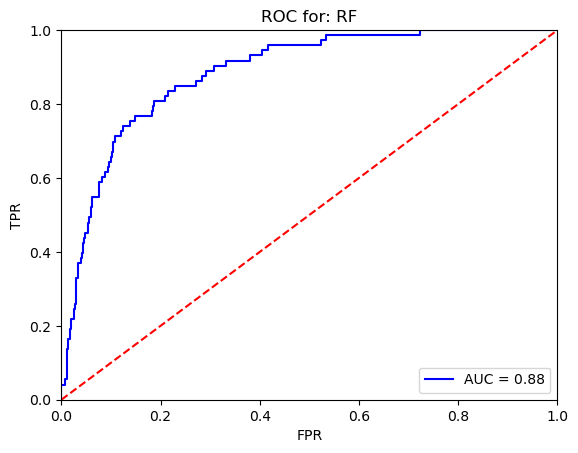

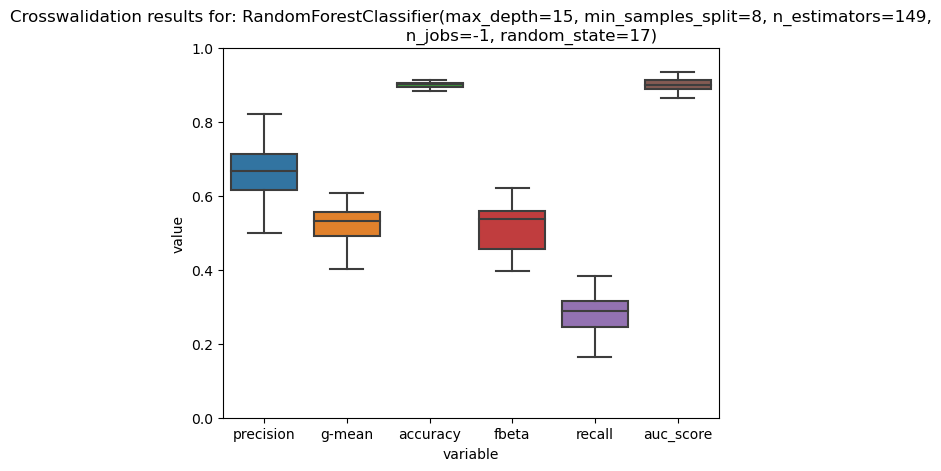

In [12]:
# Parametry dla testowego i crosswalidacyjne boxploty
param_dict={"n_jobs": -1,
            "n_estimators": opt.best_params_["model__n_estimators"],
            "criterion": opt.best_params_["model__criterion"], 
            "max_depth": opt.best_params_["model__max_depth"], 
            "min_samples_split": opt.best_params_["model__min_samples_split"], 
            "random_state": seed}

model = get_my_pipe_with_model(RandomForestClassifier(**param_dict))

base_test_model(model, X_train, X_test, y_train, y_test)
plot_roc_curve(model, "RF", X_test, y_test)
crosswalidate_model_plot(model_cal=RandomForestClassifier, 
                         param_dict=param_dict, 
                         X=bank_data.drop("y", axis = 1), 
                         y=bank_data["y"],
                         n_repeats=10)

### 1.1.2 Gmean - scorer

In [13]:
model = get_my_pipe_with_model(RandomForestClassifier(n_jobs=-1, random_state=seed))
opt = BayesSearchCV(
    estimator=model,
    search_spaces={
        "model__n_estimators": Integer(50, 150),
        "model__criterion": Categorical(["gini"]),
        "model__max_depth": Integer(4, 21),
        "model__min_samples_split": Integer(2, 8),
        "model__max_features": Integer(2, 10)
    },
    scoring=custom_gmean_scorer, # GMEAN
    random_state=seed,
    n_iter=n_iter,
    n_jobs=-1,
    cv=5
)

opt.fit(X_train, y_train)

C:\Users\barto\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['gini', 18, 9, 2, 149] before, using random point ['gini', 12, 7, 5, 99]
  warnings.warn(


BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('dropper',
                                         ColumnDropper(columns=['pdays',
                                                                'default',
                                                                'poutcome_unknown',
                                                                'poutcome_other',
                                                                'contact_unknown',
                                                                'job_unknown'])),
                                        ('balance_binner', BalanceBinner()),
                                        ('bin_previous', PreviousBinner()),
                                        ('transformer _ minmax',
                                         MinMaxTransformer(columns=['duration',
                                                                    'age',
                                                                    'campaign'])),
                                        ('model',
                                         RandomForestClassifier(n...
              search_spaces={'model__criterion': Categorical(categories=('gini',), prior=None),
                             'model__max_depth': Integer(low=4, high=21, prior='uniform', transform='normalize'),
                             'model__max_features': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'model__min_samples_split': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'model__n_estimators': Integer(low=50, high=150, prior='uniform', transform='normalize')})

Best gmean_score:  0.6171242862364565
Best params OrderedDict([('model__criterion', 'gini'), ('model__max_depth', 21), ('model__max_features', 9), ('model__min_samples_split', 2), ('model__n_estimators', 145)])
------------------------------------------------------------------------------------------------
Precision score: 0.5666666666666667
G-mean score:    0.47693882814524924
Accuracy score:  0.8909952606635071
Fbeta_score:     0.4404145077720207
Recall score: 0.2328767123287671
Confusion matrix: 
 [[547  13]
 [ 56  17]]


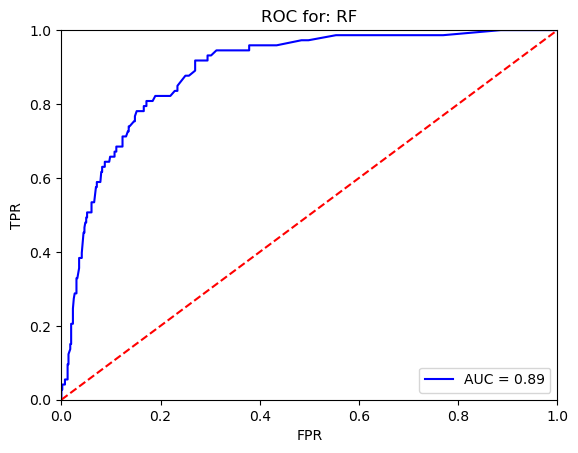

------------------------------------------------------------------------------------------------


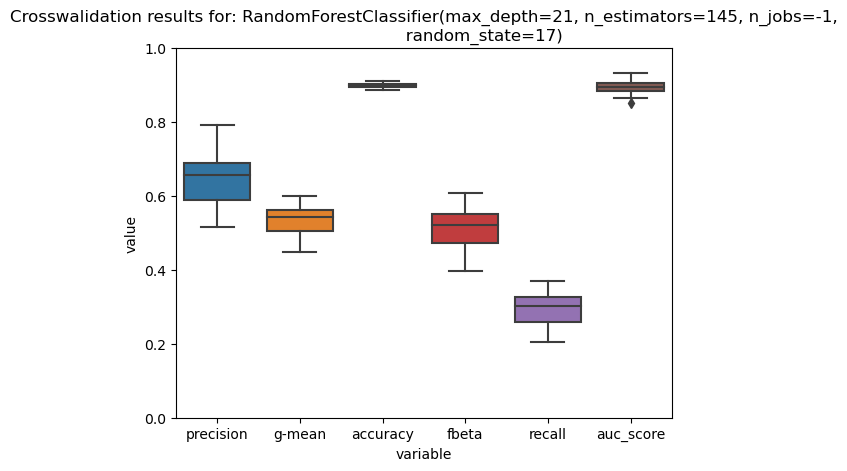

In [14]:
# Jakie parametry wygrały
print("Best gmean_score: ", opt.best_score_)
print("Best params", opt.best_params_)
print("------------------------------------------------------------------------------------------------")

# Jak zadziałał na zbiorze testowym
param_dict={"n_jobs": -1,
            "n_estimators": opt.best_params_["model__n_estimators"],
            "criterion": opt.best_params_["model__criterion"], 
            "max_depth": opt.best_params_["model__max_depth"], 
            "min_samples_split": opt.best_params_["model__min_samples_split"], 
            "random_state": seed}

model  = get_my_pipe_with_model(RandomForestClassifier(**param_dict))

base_test_model(model, X_train, X_test, y_train, y_test)
plot_roc_curve(model, "RF", X_test, y_test)
print("------------------------------------------------------------------------------------------------")

crosswalidate_model_plot(model_cal=RandomForestClassifier, 
                         param_dict=param_dict, 
                         X=bank_data.drop("y", axis = 1), 
                         y=bank_data["y"],
                         n_repeats=10)

In [15]:
params_for_rf = param_dict

## 1.2 GradientBooster

In [16]:
from sklearn.ensemble import HistGradientBoostingClassifier

### 1.2.1 Fbeta scorer

In [17]:
model = get_my_pipe_with_model(HistGradientBoostingClassifier())
opt = GridSearchCV(
    estimator=model,
    param_grid={
        "model__learning_rate": [0.05, 0.1, 0.2],
        "model__max_iter": [1000],
        "model__max_depth": [2, 3, 5, 8, 30],
        "model__max_leaf_nodes": [10, 30, None],
        "model__l2_regularization": [0, 0.1, 0.5, 1, 10],
        "model__random_state": [seed]
    },
    scoring=custom_fbeta_scorer, #fbeta z parametrem beta=0.5 (sprzyja bardziej precision)
    n_jobs=-1,
    cv=5
)

opt.fit(X_train, y_train)
print("Best fbeta: ", opt.best_score_)
print("Best params: ", opt.best_params_)
print("------------------------------------------------------------------------------------------------")

Best fbeta:  0.5502266588472776
Best params:  {'model__l2_regularization': 10, 'model__learning_rate': 0.05, 'model__max_depth': 2, 'model__max_iter': 1000, 'model__max_leaf_nodes': 10, 'model__random_state': 17}
------------------------------------------------------------------------------------------------


Precision score: 0.625
G-mean score:    0.4496410832188264
Accuracy score:  0.8941548183254344
Fbeta_score:     0.4437869822485207
Recall score: 0.2054794520547945
Confusion matrix: 
 [[551   9]
 [ 58  15]]


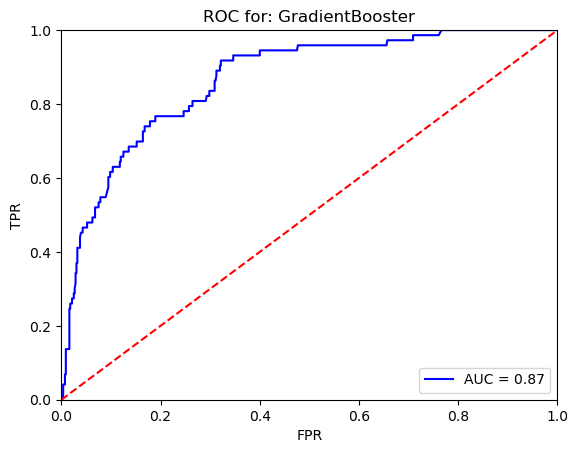

------------------------------------------------------------------------------------------------


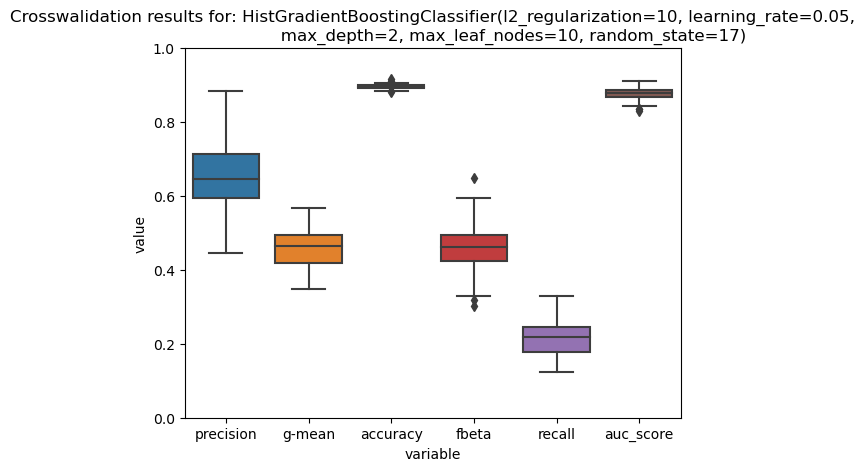

In [18]:
# Jak zadziałał na zbiorze testowym
param_dict = {
    "l2_regularization": opt.best_params_["model__l2_regularization"],
    "learning_rate": opt.best_params_["model__learning_rate"],
    "max_depth": opt.best_params_["model__max_depth"],
    "max_leaf_nodes": opt.best_params_["model__max_leaf_nodes"],
    "random_state": seed
}
model = get_my_pipe_with_model(HistGradientBoostingClassifier(**param_dict))

base_test_model(model, X_train, X_test, y_train, y_test)
plot_roc_curve(model, "GradientBooster", X_test, y_test)
print("------------------------------------------------------------------------------------------------")

crosswalidate_model_plot(model_cal=HistGradientBoostingClassifier, 
                         param_dict=param_dict, 
                         X=bank_data.drop("y", axis = 1), 
                         y=bank_data["y"],
                         n_repeats=10)

### 1.2.2 GMean

In [19]:
model = get_my_pipe_with_model(HistGradientBoostingClassifier())
opt = GridSearchCV(
    estimator=model,
    param_grid={
        "model__learning_rate": [0.05, 0.1, 0.2],
        "model__max_iter": [1000],
        "model__max_depth": [3, 5, 8, 30],
        "model__max_leaf_nodes": [10, 30, None],
        "model__l2_regularization": [0, 0.1, 0.5, 1, 10],
        "model__random_state": [seed]
    },
    scoring=custom_gmean_scorer, #GMEAN
    n_jobs=-1,
    cv=5
)

opt.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('dropper',
                                        ColumnDropper(columns=['pdays',
                                                               'default',
                                                               'poutcome_unknown',
                                                               'poutcome_other',
                                                               'contact_unknown',
                                                               'job_unknown'])),
                                       ('balance_binner', BalanceBinner()),
                                       ('bin_previous', PreviousBinner()),
                                       ('transformer _ minmax',
                                        MinMaxTransformer(columns=['duration',
                                                                   'age',
                                                                   'campaign'])),
                                       ('model',
                                        HistGradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'model__l2_regularization': [0, 0.1, 0.5, 1, 10],
                         'model__learning_rate': [0.05, 0.1, 0.2],
                         'model__max_depth': [3, 5, 8, 30],
                         'model__max_iter': [1000],
                         'model__max_leaf_nodes': [10, 30, None],
                         'model__random_state': [17]},
             scoring=<function custom_gmean_scorer at 0x0000028D990AB740>)

Best gmean:  0.6551926695613407
Best params:  {'model__l2_regularization': 0.5, 'model__learning_rate': 0.2, 'model__max_depth': 3, 'model__max_iter': 1000, 'model__max_leaf_nodes': 10, 'model__random_state': 17}
------------------------------------------------------------------------------------------------
Precision score: 0.5882352941176471
G-mean score:    0.6289260252251289
Accuracy score:  0.8988941548183255
Fbeta_score:     0.5415162454873645
Recall score: 0.410958904109589
Confusion matrix: 
 [[539  21]
 [ 43  30]]


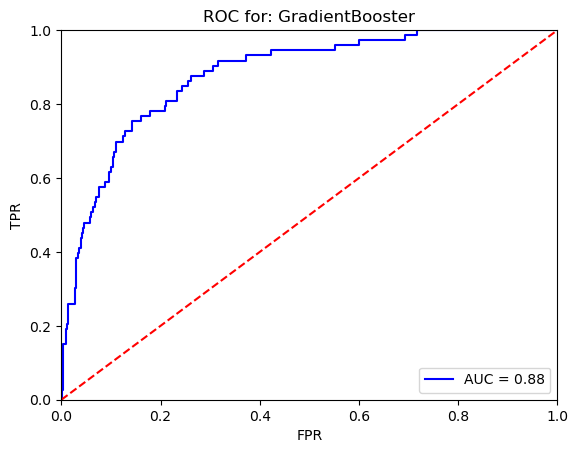

------------------------------------------------------------------------------------------------


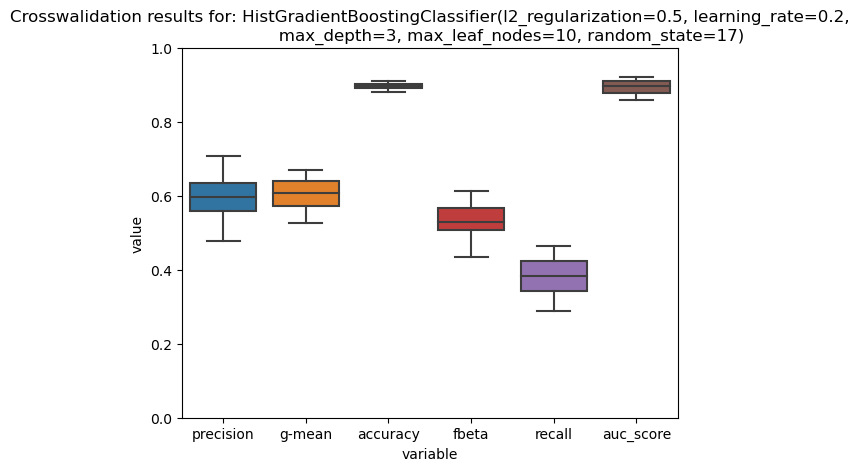

In [20]:
print("Best gmean: ", opt.best_score_)
print("Best params: ", opt.best_params_)
print("------------------------------------------------------------------------------------------------")
# Jak zadziałał na zbiorze testowym
param_dict = {
    "l2_regularization": opt.best_params_["model__l2_regularization"],
    "learning_rate": opt.best_params_["model__learning_rate"],
    "max_depth": opt.best_params_["model__max_depth"],
    "max_leaf_nodes": opt.best_params_["model__max_leaf_nodes"],
    "random_state": seed
}
model = get_my_pipe_with_model(HistGradientBoostingClassifier(**param_dict))

base_test_model(model, X_train, X_test, y_train, y_test)
plot_roc_curve(model, "GradientBooster", X_test, y_test)
print("------------------------------------------------------------------------------------------------")

crosswalidate_model_plot(model_cal=HistGradientBoostingClassifier, 
                         param_dict=param_dict, 
                         X=bank_data.drop("y", axis = 1), 
                         y=bank_data["y"],
                         n_repeats=10)

In [21]:
params_for_gradient_booster = param_dict

## 1. 3 XGB

In [22]:
from xgboost import XGBClassifier

### 1.3.1 fbeta - scorer

In [23]:
model = get_my_pipe_with_model(XGBClassifier())
opt = GridSearchCV(
    estimator=model,
    param_grid={
        "model__eta": [0.05, 0.1, 0.2],
        "model__max_depth": [3, 6, 12, 30],
        "model__gamma": [0, 10, 30, None],
        "model__min_child_weigth": [0.1, 0.5, 1, 10],
        "model__lambda": [0.1, 0.5, 1],
        "model__alpha": [0, 0.5, 1],
        "model__scale_pos_weight": [1, 90],
        "model__random_state": [seed]
    },
    scoring=custom_fbeta_scorer, #fbeta z parametrem beta=0.5 (sprzyja bardziej precision)
    n_jobs=-1,
    cv=5
)

opt.fit(X_train, y_train)

C:\Users\barto\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:06:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_child_weigth" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('dropper',
                                        ColumnDropper(columns=['pdays',
                                                               'default',
                                                               'poutcome_unknown',
                                                               'poutcome_other',
                                                               'contact_unknown',
                                                               'job_unknown'])),
                                       ('balance_binner', BalanceBinner()),
                                       ('bin_previous', PreviousBinner()),
                                       ('transformer _ minmax',
                                        MinMaxTransformer(columns=['duration',
                                                                   'age',
                                                                   'campaign'])),
                                       ('model',
                                        XGBClassifier(base_score=...
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'model__alpha': [0, 0.5, 1],
                         'model__eta': [0.05, 0.1, 0.2],
                         'model__gamma': [0, 10, 30, None],
                         'model__lambda': [0.1, 0.5, 1],
                         'model__max_depth': [3, 6, 12, 30],
                         'model__min_child_weigth': [0.1, 0.5, 1, 10],
                         'model__random_state': [17],
                         'model__scale_pos_weight': [1, 90]},
             scoring=<function custom_fbeta_scorer at 0x0000028D92DB32E0>)

C:\Users\barto\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:06:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_child_weigth" } are not used.

  warnings.warn(smsg, UserWarning)


Best fbeta:  0.5552000217367297
Best params:  {'model__alpha': 1, 'model__eta': 0.1, 'model__gamma': 0, 'model__lambda': 1, 'model__max_depth': 3, 'model__min_child_weigth': 0.1, 'model__random_state': 17, 'model__scale_pos_weight': 1}
------------------------------------------------------------------------------------------------
Precision score: 0.4878048780487805
G-mean score:    0.5135159492527825
Accuracy score:  0.8830963665086888
Fbeta_score:     0.42194092827004215
Recall score: 0.273972602739726
Confusion matrix: 
 [[539  21]
 [ 53  20]]


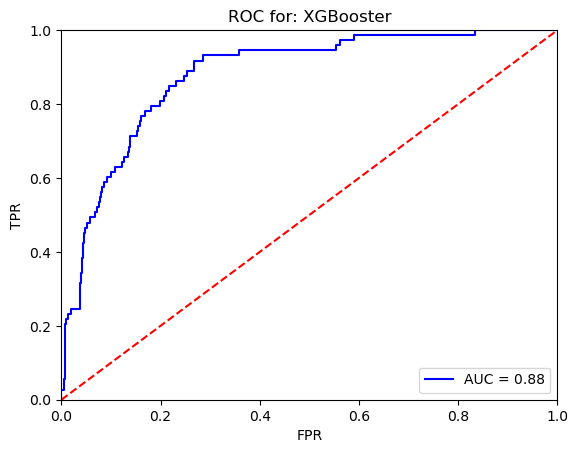

------------------------------------------------------------------------------------------------


C:\Users\barto\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:06:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_child_weigth" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\barto\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:06:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_child_weigth" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\barto\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:06:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_child_weigth" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\barto\anaconda3\Lib\site-packages\xgb

C:\Users\barto\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:06:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_child_weigth" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\barto\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:06:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_child_weigth" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\barto\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:06:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_child_weigth" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\barto\anaconda3\Lib\site-packages\xgb

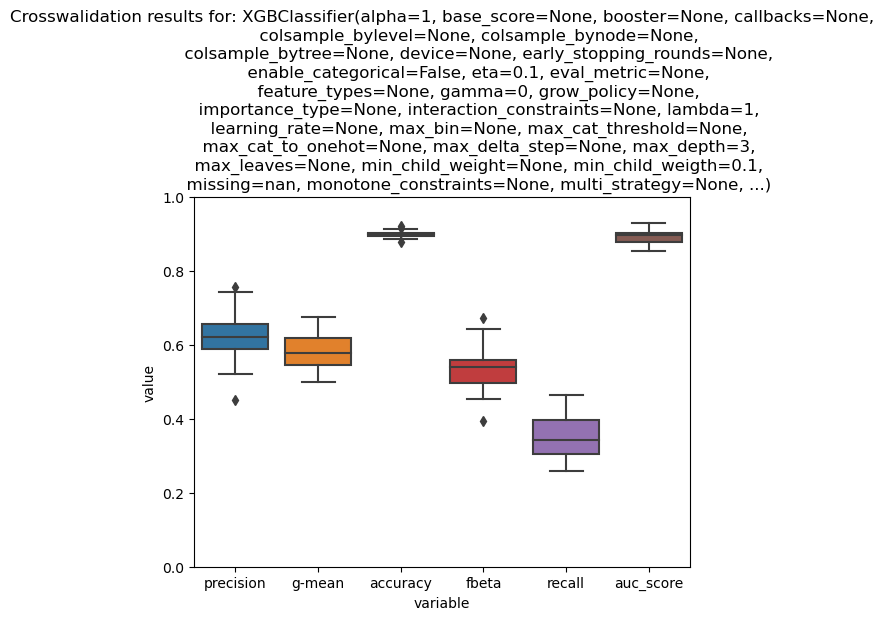

In [24]:
print("Best fbeta: ", opt.best_score_)
print("Best params: ", opt.best_params_)
print("------------------------------------------------------------------------------------------------")
# Jak zadziałał na zbiorze testowym
param_dict = {
    "eta": opt.best_params_["model__eta"],
    "max_depth": opt.best_params_["model__max_depth"],
    "gamma": opt.best_params_["model__gamma"],
    "min_child_weigth": opt.best_params_["model__min_child_weigth"],
    "lambda": opt.best_params_["model__lambda"],
    "alpha": opt.best_params_["model__alpha"],
    "scale_pos_weight": opt.best_params_["model__scale_pos_weight"],
    "random_state": seed
}
model = get_my_pipe_with_model(XGBClassifier(**param_dict))

base_test_model(model, X_train, X_test, y_train, y_test)
plot_roc_curve(model, "XGBooster", X_test, y_test)
print("------------------------------------------------------------------------------------------------")

crosswalidate_model_plot(model_cal=XGBClassifier, 
                         param_dict=param_dict, 
                         X=bank_data.drop("y", axis = 1), 
                         y=bank_data["y"],
                         n_repeats=10)

### 1.3.2 gmean_scorer

In [25]:
model = get_my_pipe_with_model(XGBClassifier())
opt = GridSearchCV(
    estimator=model,
    param_grid={
        "model__eta": [0.05, 0.1, 0.2],
        "model__max_depth": [3, 6, 12, 30],
        "model__gamma": [0, 10, 30, None],
        "model__min_child_weigth": [0.1, 0.5, 1, 10],
        "model__lambda": [0.1, 0.5, 1],
        "model__alpha": [0, 0.5, 1],
        "model__scale_pos_weight": [1, 90],
        "model__random_state": [seed]
    },
    scoring=custom_gmean_scorer, #gmean
    n_jobs=-1,
    cv=5
)

opt.fit(X_train, y_train)

C:\Users\barto\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\barto\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:26:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_child_weigth" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('dropper',
                                        ColumnDropper(columns=['pdays',
                                                               'default',
                                                               'poutcome_unknown',
                                                               'poutcome_other',
                                                               'contact_unknown',
                                                               'job_unknown'])),
                                       ('balance_binner', BalanceBinner()),
                                       ('bin_previous', PreviousBinner()),
                                       ('transformer _ minmax',
                                        MinMaxTransformer(columns=['duration',
                                                                   'age',
                                                                   'campaign'])),
                                       ('model',
                                        XGBClassifier(base_score=...
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'model__alpha': [0, 0.5, 1],
                         'model__eta': [0.05, 0.1, 0.2],
                         'model__gamma': [0, 10, 30, None],
                         'model__lambda': [0.1, 0.5, 1],
                         'model__max_depth': [3, 6, 12, 30],
                         'model__min_child_weigth': [0.1, 0.5, 1, 10],
                         'model__random_state': [17],
                         'model__scale_pos_weight': [1, 90]},
             scoring=<function custom_gmean_scorer at 0x0000028D990AB740>)

C:\Users\barto\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:26:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_child_weigth" } are not used.

  warnings.warn(smsg, UserWarning)


Best gmean:  0.8209048595766173
Best params:  {'model__alpha': 0.5, 'model__eta': 0.05, 'model__gamma': 10, 'model__lambda': 1, 'model__max_depth': 30, 'model__min_child_weigth': 0.1, 'model__random_state': 17, 'model__scale_pos_weight': 90}
------------------------------------------------------------------------------------------------
Precision score: 0.33689839572192515
G-mean score:    0.8197059278907151
Accuracy score:  0.7883096366508688
Fbeta_score:     0.38367844092570036
Recall score: 0.863013698630137
Confusion matrix: 
 [[436 124]
 [ 10  63]]


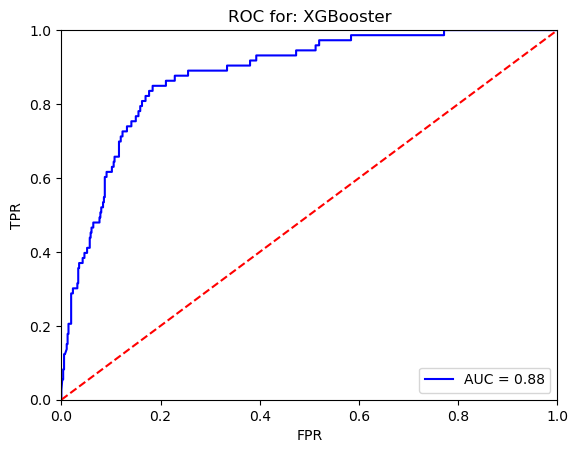

------------------------------------------------------------------------------------------------


C:\Users\barto\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:26:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_child_weigth" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\barto\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:26:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_child_weigth" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\barto\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:26:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_child_weigth" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\barto\anaconda3\Lib\site-packages\xgb

C:\Users\barto\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:26:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_child_weigth" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\barto\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:26:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_child_weigth" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\barto\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:26:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_child_weigth" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\barto\anaconda3\Lib\site-packages\xgb

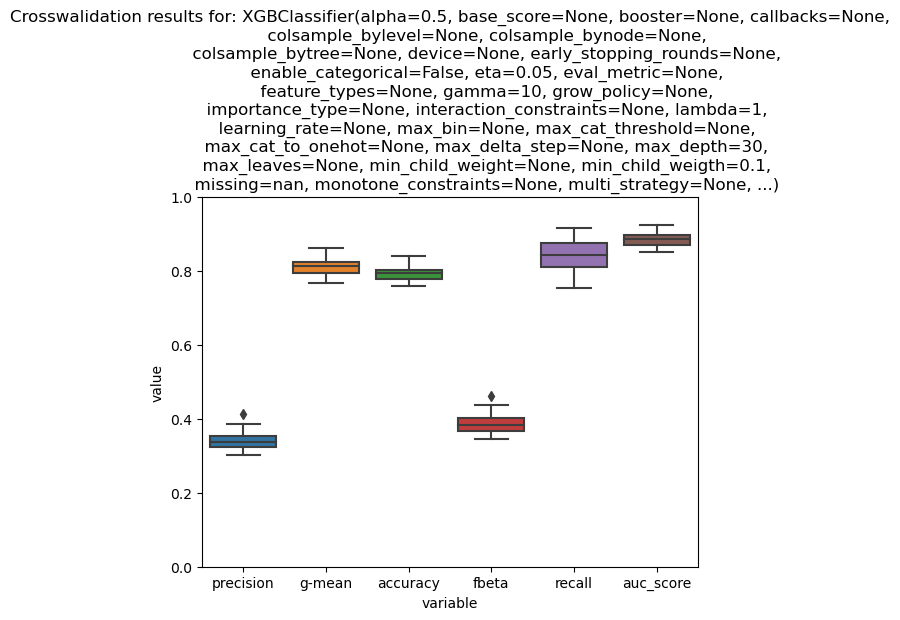

In [26]:
print("Best gmean: ", opt.best_score_)
print("Best params: ", opt.best_params_)
print("------------------------------------------------------------------------------------------------")
# Jak zadziałał na zbiorze testowym
param_dict = {
    "eta": opt.best_params_["model__eta"],
    "max_depth": opt.best_params_["model__max_depth"],
    "gamma": opt.best_params_["model__gamma"],
    "min_child_weigth": opt.best_params_["model__min_child_weigth"],
    "lambda": opt.best_params_["model__lambda"],
    "alpha": opt.best_params_["model__alpha"],
    "scale_pos_weight": opt.best_params_["model__scale_pos_weight"],
    "random_state": seed
}
model = get_my_pipe_with_model(XGBClassifier(**param_dict))

base_test_model(model, X_train, X_test, y_train, y_test)
plot_roc_curve(model, "XGBooster", X_test, y_test)
print("------------------------------------------------------------------------------------------------")

crosswalidate_model_plot(model_cal=XGBClassifier, 
                         param_dict=param_dict, 
                         X=bank_data.drop("y", axis = 1), 
                         y=bank_data["y"],
                         n_repeats=10)

In [27]:
params_for_xgb = param_dict

## 1.4 SVC

In [28]:
from sklearn.svm import SVC

### 1.4.1 Fbeta

Best fbeta:  0.3808809344442915
Best params: {'model__degree': 1, 'model__kernel': 'poly', 'model__max_iter': 150000, 'model__probability': True, 'model__random_state': 17}
------------------------------------------------------------------------------------------------
Precision score: 0.7916666666666666
G-mean score:    0.5078878792089432
Accuracy score:  0.9067930489731437
Fbeta_score:     0.5621301775147929
Recall score: 0.2602739726027397
Confusion matrix: 
 [[555   5]
 [ 54  19]]


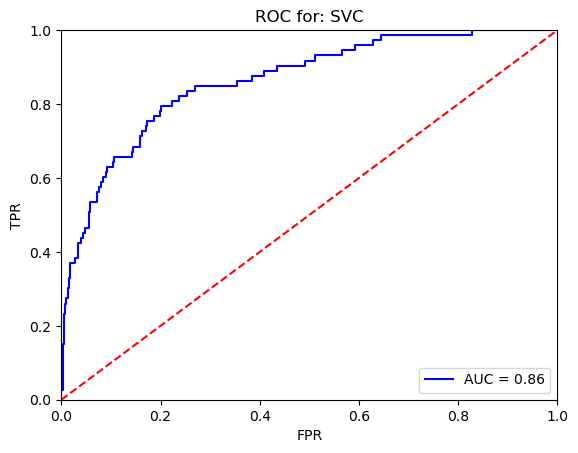

------------------------------------------------------------------------------------------------


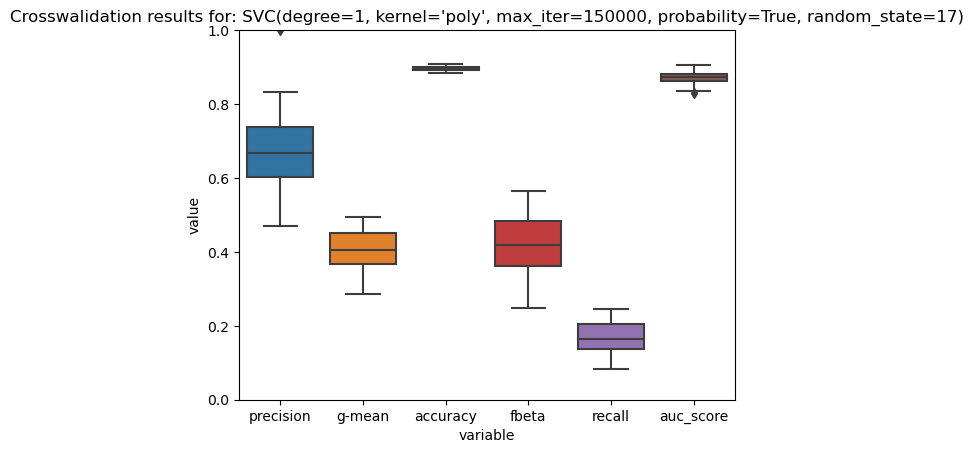

In [29]:
model = get_my_pipe_with_model(SVC())
opt = GridSearchCV(
    estimator=model,
    param_grid={
        "model__kernel": ["linear", "poly", "rbf", "sigmoid"],
        "model__degree": [1, 3, 5, 7],
        "model__max_iter": [150000],
        "model__random_state": [seed],
        "model__probability": [True]
    },
    scoring=custom_fbeta_scorer, # beta
    cv=5
)

opt.fit(X_train, y_train)
print("Best fbeta: ", opt.best_score_)
print("Best params:", opt.best_params_)
print("------------------------------------------------------------------------------------------------")

# Jak zadziałał na zbiorze testowym
param_dict = {
    "kernel": opt.best_params_["model__kernel"],
    "degree": opt.best_params_["model__degree"],
    "max_iter": opt.best_params_["model__max_iter"],
    "random_state": seed,
    "probability": True
}
model = get_my_pipe_with_model(SVC(**param_dict))

base_test_model(model, X_train, X_test, y_train, y_test)
plot_roc_curve(model, "SVC", X_test, y_test)
print("------------------------------------------------------------------------------------------------")

crosswalidate_model_plot(model_cal=SVC, 
                         param_dict=param_dict, 
                         X=bank_data.drop("y", axis = 1), 
                         y=bank_data["y"],
                         n_repeats=10)

In [30]:
params_for_svc = param_dict

### 1.4.2 - gmean

Best gmean:  0.42043498558730885
------------------------------------------------------------------------------------------------
Precision score: 0.4864864864864865
G-mean score:    0.4880669967805441
Accuracy score:  0.8830963665086888
Fbeta_score:     0.40723981900452494
Recall score: 0.2465753424657534
Confusion matrix: 
 [[541  19]
 [ 55  18]]


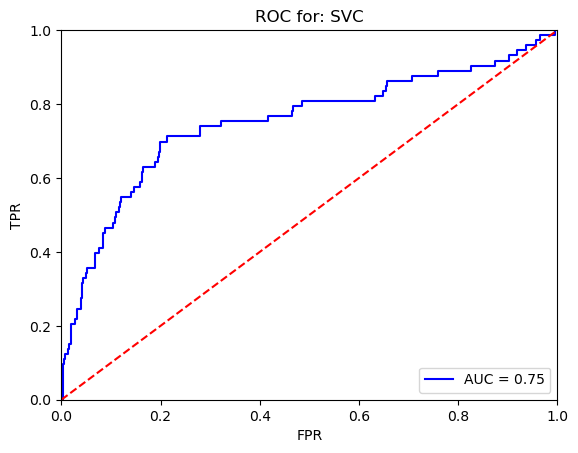

------------------------------------------------------------------------------------------------


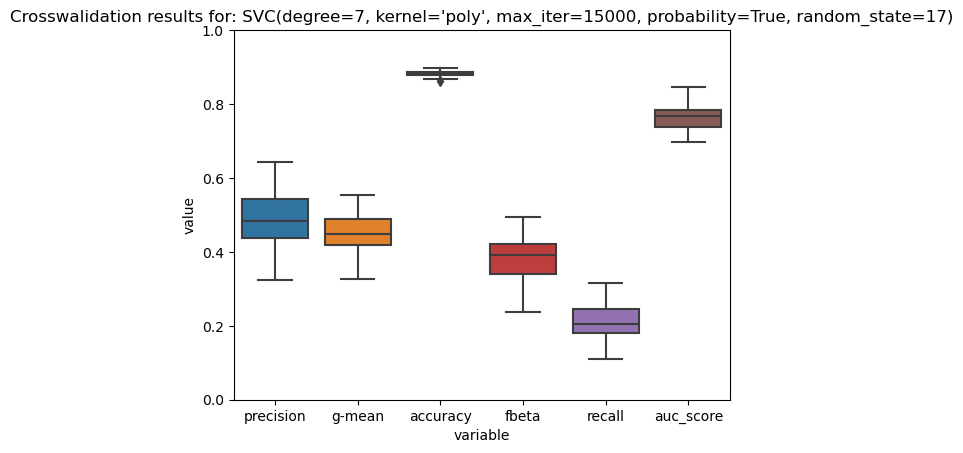

In [31]:
model = get_my_pipe_with_model(SVC())
opt = GridSearchCV(
    estimator=model,
    param_grid={
        "model__kernel": ["linear", "poly", "rbf", "sigmoid"],
        "model__degree": [1, 3, 5, 7],
        "model__max_iter": [15000],
        "model__random_state": [seed]
    },
    scoring=custom_gmean_scorer, # g_mean
    n_jobs=-1,
    cv=5,
    error_score='raise'
)

opt.fit(X_train, y_train)
print("Best gmean: ", opt.best_score_)
print("------------------------------------------------------------------------------------------------")

# Jak zadziałał na zbiorze testowym
param_dict = {
    "kernel": opt.best_params_["model__kernel"],
    "degree": opt.best_params_["model__degree"],
    "max_iter": opt.best_params_["model__max_iter"],
    "random_state": seed,
    "probability": True
}
model = get_my_pipe_with_model(SVC(**param_dict))

base_test_model(model, X_train, X_test, y_train, y_test)
plot_roc_curve(model, "SVC", X_test, y_test)
print("------------------------------------------------------------------------------------------------")

crosswalidate_model_plot(model_cal=SVC, 
                         param_dict=param_dict, 
                         X=bank_data.drop("y", axis = 1), 
                         y=bank_data["y"],
                         n_repeats=10)

# 2. Stacking

In [36]:
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

C:\Users\barto\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:32:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_child_weigth" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\barto\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:32:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_child_weigth" } are not used.

  warnings.warn(smsg, UserWarning)


Precision score: 0.627906976744186
G-mean score:    0.5994126283467227
Accuracy score:  0.9020537124802528
Fbeta_score:     0.5510204081632653
Recall score: 0.3698630136986301
Confusion matrix: 
 [[544  16]
 [ 46  27]]


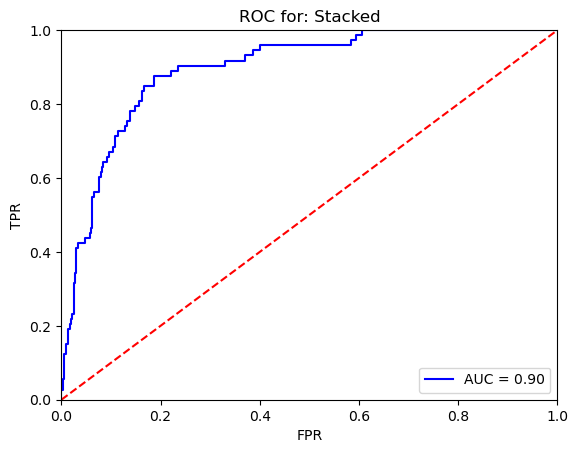

In [35]:
level0 = list()
level0.append(("rf", RandomForestClassifier(**params_for_rf)))
level0.append(("gradient_booster", HistGradientBoostingClassifier(**params_for_gradient_booster)))
level0.append(("xgb", XGBClassifier(**params_for_xgb)))
level0.append(("svc", SVC(**params_for_svc)))

level1 = LogisticRegression()

pipe = get_my_pipe_with_model(StackingClassifier(estimators = level0, final_estimator = level1, cv=5))
base_test_model(pipe, X_train, X_test, y_train, y_test)
plot_roc_curve(pipe, "Stacked", X_test, y_test)

C:\Users\barto\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:36:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_child_weigth" } are not used.

  warnings.warn(smsg, UserWarning)


Precision score: 0.6326530612244898
G-mean score:    0.6410989219992884
Accuracy score:  0.9052132701421801
Fbeta_score:     0.5762081784386618
Recall score: 0.4246575342465753
Confusion matrix: 
 [[542  18]
 [ 42  31]]


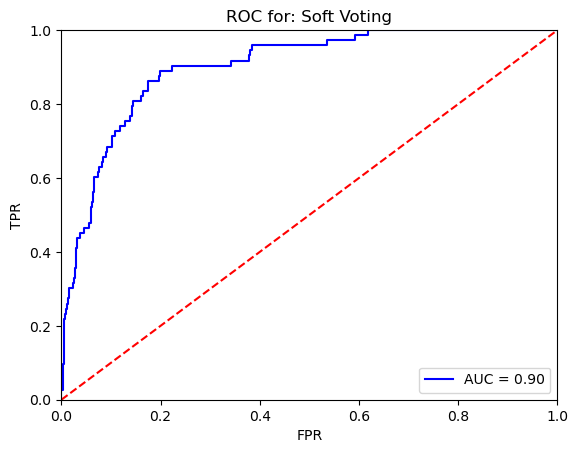

In [39]:
pipe = get_my_pipe_with_model(VotingClassifier(estimators=level0, voting="soft"))
base_test_model(pipe, X_train, X_test, y_train, y_test)
plot_roc_curve(pipe, "Soft Voting", X_test, y_test)

In [41]:
### Crosswalidację trzeba od nowa znowu niestety
import os
os.system('jupyter nbconvert --to html model_and_hyperparameters.ipynb')

0